In [24]:
!nvidia-smi

Sun May  1 19:13:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |   4874MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
!pip install huggingface
!pip install datasets
!pip install transformers
!pip install rouge-score
!pip install torchplot

In [26]:
import huggingface
from datasets import load_dataset
from transformers import pipeline
import nltk
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import stats

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
device = torch.device('cuda')

In [28]:
cnn_daily = load_dataset('cnn_dailymail','3.0.0')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
small_train_dataset = cnn_daily["train"].shuffle(seed=42).select(range(1000))
small_valid_dataset = cnn_daily["validation"].shuffle(seed=42).select(range(1000))
small_test_dataset = cnn_daily["test"].shuffle(seed=42).select(range(5000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-6515e5a88713b87d.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-8574e5f176906dfb.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-910a0e10eda294ba.arrow


In [30]:
from transformers import BertTokenizer, BertModel

In [31]:
sample = {'article': 'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because he wants to. "While I believe I have the authority to carry out this military action without specific congressional authorization, I know that the country will be stronger if we take this course, and our actions will be even more effective," he said. "We should have this debate, because the issues are too big for business as usual." Obama said top congressional leaders had agreed to schedule a debate when the body returns to Washington on September 9. The Senate Foreign Relations Committee will hold a hearing over the matter on Tuesday, Sen. Robert Menendez said. Transcript: Read Obama\'s full remarks . Syrian crisis: Latest developments . U.N. inspectors leave Syria . Obama\'s remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb. "The aim of the game here, the mandate, is very clear -- and that is to ascertain whether chemical weapons were used -- and not by whom," U.N. spokesman Martin Nesirky told reporters on Saturday. But who used the weapons in the reported toxic gas attack in a Damascus suburb on August 21 has been a key point of global debate over the Syrian crisis. Top U.S. officials have said there\'s no doubt that the Syrian government was behind it, while Syrian officials have denied responsibility and blamed jihadists fighting with the rebels. British and U.S. intelligence reports say the attack involved chemical weapons, but U.N. officials have stressed the importance of waiting for an official report from inspectors. The inspectors will share their findings with U.N. Secretary-General Ban Ki-moon Ban, who has said he wants to wait until the U.N. team\'s final report is completed before presenting it to the U.N. Security Council. The Organization for the Prohibition of Chemical Weapons, which nine of the inspectors belong to, said Saturday that it could take up to three weeks to analyze the evidence they collected. "It needs time to be able to analyze the information and the samples," Nesirky said. He noted that Ban has repeatedly said there is no alternative to a political solution to the crisis in Syria, and that "a military solution is not an option." Bergen:  Syria is a problem from hell for the U.S. Obama: \'This menace must be confronted\' Obama\'s senior advisers have debated the next steps to take, and the president\'s comments Saturday came amid mounting political pressure over the situation in Syria. Some U.S. lawmakers have called for immediate action while others warn of stepping into what could become a quagmire. Some global leaders have expressed support, but the British Parliament\'s vote against military action earlier this week was a blow to Obama\'s hopes of getting strong backing from key NATO allies. On Saturday, Obama proposed what he said would be a limited military action against Syrian President Bashar al-Assad. Any military attack would not be open-ended or include U.S. ground forces, he said. Syria\'s alleged use of chemical weapons earlier this month "is an assault on human dignity," the president said. A failure to respond with force, Obama argued,  "could lead to escalating use of chemical weapons or their proliferation to terrorist groups who would do our people harm. In a world with many dangers, this menace must be confronted." Syria missile strike: What would happen next? Map: U.S. and allied assets around Syria . Obama decision came Friday night . On Friday night, the president made a last-minute decision to consult lawmakers. What will happen if they vote no? It\'s unclear. A senior administration official told CNN that Obama has the authority to act without Congress -- even if Congress rejects his request for authorization to use force. Obama on Saturday continued to shore up support for a strike on the al-Assad government. He spoke by phone with French President Francois Hollande before his Rose Garden speech. "The two leaders agreed that the international community must deliver a resolute message to the Assad regime -- and others who would consider using chemical weapons -- that these crimes are unacceptable and those who violate this international norm will be held accountable by the world," the White House said. Meanwhile, as uncertainty loomed over how Congress would weigh in, U.S. military officials said they remained at the ready. 5 key assertions: U.S. intelligence report on Syria . Syria: Who wants what after chemical weapons horror . Reactions mixed to Obama\'s speech . A spokesman for the Syrian National Coalition said that the opposition group was disappointed by Obama\'s announcement. "Our fear now is that the lack of action could embolden the regime and they repeat his attacks in a more serious way," said spokesman Louay Safi. "So we are quite concerned." Some members of Congress applauded Obama\'s decision. House Speaker John Boehner, Majority Leader Eric Cantor, Majority Whip Kevin McCarthy and Conference Chair Cathy McMorris Rodgers issued a statement Saturday praising the president. "Under the Constitution, the responsibility to declare war lies with Congress," the Republican lawmakers said. "We are glad the president is seeking authorization for any military action in Syria in response to serious, substantive questions being raised." More than 160 legislators, including 63 of Obama\'s fellow Democrats, had signed letters calling for either a vote or at least a "full debate" before any U.S. action. British Prime Minister David Cameron, whose own attempt to get lawmakers in his country to support military action in Syria failed earlier this week, responded to Obama\'s speech in a Twitter post Saturday. "I understand and support Barack Obama\'s position on Syria," Cameron said. An influential lawmaker in Russia -- which has stood by Syria and criticized the United States -- had his own theory. "The main reason Obama is turning to the Congress:  the military operation did not get enough support either in the world, among allies of the US or in the United States itself," Alexei Pushkov, chairman of the international-affairs committee of the Russian State Duma, said in a Twitter post. In the United States, scattered groups of anti-war protesters around the country took to the streets Saturday. "Like many other Americans...we\'re just tired of the United States getting involved and invading and bombing other countries," said Robin Rosecrans, who was among hundreds at a Los Angeles demonstration. What do Syria\'s neighbors think? Why Russia, China, Iran stand by Assad . Syria\'s government unfazed . After Obama\'s speech, a military and political analyst on Syrian state TV said Obama is "embarrassed" that Russia opposes military action against Syria, is "crying for help" for someone to come to his rescue and is facing two defeats -- on the political and military levels. Syria\'s prime minister appeared unfazed by the saber-rattling. "The Syrian Army\'s status is on maximum readiness and fingers are on the trigger to confront all challenges," Wael Nader al-Halqi said during a meeting with a delegation of Syrian expatriates from Italy, according to a banner on Syria State TV that was broadcast prior to Obama\'s address. An anchor on Syrian state television said Obama "appeared to be preparing for an aggression on Syria based on repeated lies." A top Syrian diplomat told the state television network that Obama was facing pressure to take military action from Israel, Turkey, some Arabs and right-wing extremists in the United States. "I think he has done well by doing what Cameron did in terms of taking the issue to Parliament," said Bashar Jaafari, Syria\'s ambassador to the United Nations. Both Obama and Cameron, he said, "climbed to the top of the tree and don\'t know how to get down." The Syrian government has denied that it used chemical weapons in the August 21 attack, saying that jihadists fighting with the rebels used them in an effort to turn global sentiments against it. British intelligence had put the number of people killed in the attack at more than 350. On Saturday, Obama said "all told, well over 1,000 people were murdered." U.S. Secretary of State John Kerry on Friday cited a death toll of 1,429, more than 400 of them children. No explanation was offered for the discrepancy. Iran: U.S. military action in Syria would spark \'disaster\' Opinion: Why strikes in Syria are a bad idea .',
 'highlights': 'Syrian official: Obama climbed to the top of the tree, "doesn\'t know how to get down"\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .',
 'id': '0001d1afc246a7964130f43ae940af6bc6c57f01'}

In [32]:
batchsize=1
bertbase = BertModel.from_pretrained("bert-base-uncased")
Btokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class WordImportance(nn.Module):
    def __init__(self):
          super(WordImportance, self).__init__()
          self.bert = bertbase
          self.tokenizer = Btokenizer
          self.get_query = nn.Linear(768,768)
          self.get_key = nn.Linear(768,768)          


    def forward(self, x):
          
          embedding = self.bert(**x)

          from_tensor = embedding['last_hidden_state']
          to_tensor = embedding['last_hidden_state']

          query_for_attention = self.get_query(from_tensor)
          query_size = query_for_attention.size()
          query_for_attention = query_for_attention.reshape(query_size[-2],query_size[-1])
          key_for_attention = self.get_key(to_tensor)
          key_size = key_for_attention.size()
          key_for_attention = key_for_attention.reshape(key_size[-2],key_size[-1])
          
          attention_score = torch.matmul(query_for_attention,key_for_attention.transpose(0,1))/torch.sqrt(torch.tensor(768))
          attention_size = attention_score.size()
          attention_distribution = F.softmax(attention_score.reshape(attention_size[-2]*attention_size[-1])).reshape(attention_size[-2],attention_size[-1]).sum(1)
          attention_seq_len = attention_distribution.size()[-1]
          attention_distribution = attention_distribution.reshape(attention_seq_len,1,1)
       

          return attention_distribution

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
model = WordImportance().to(device)
encoded_input = Btokenizer(sample['article'],padding='max_length',truncation=True, return_tensors='pt').to(device)
wordscore = model(x = encoded_input)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
import gensim
from gensim import summarization
from itertools import combinations
import random

In [35]:
class SummaryGenerator(nn.Module):
# x is tokens in article
# budget is num of sentence extracted as summary
# text is article where extracted summarization comes from as well as tokens (x)  

  def text_split(self,text):
    split_text = []
    for sentence in summarization.textcleaner.get_sentences(text):
      split_text.append(sentence)
    return split_text   

  def get_truncation_length(self,splited_text):
    truncation_length = []
    for sent in splited_text:
      truncation_length.append(len(Btokenizer.tokenize(sent)))

    return truncation_length


  def get_sentence_score(self, wordscore, truncation_length):
    add = 0
    sentence_score = []
    for i,length in enumerate(truncation_length):
      prob_seq = wordscore[range(add,add+length)]
      score = -torch.mul(prob_seq,prob_seq.log()).sum() + prob_seq.sum()
      sentence_score.append(score)
      add = add + length

    return sentence_score#geometric_mean_score

  def find_important_sentence_hard(self, score,budget):
    score = torch.Tensor(score)
    order = []
    while budget>0:
      best_sent = torch.where(score==score.max())[0].tolist()
      num_best_sent = len(best_sent)
      if num_best_sent>budget:
        order =  best_sent[0:budget]
        budget = budget - budget

      else:
        order = order + best_sent
        for i in best_sent:
          score[i] = 0
        budget = budget - num_best_sent
    return order
    

  def forward(self,text,wordscore,budget): 
    split_text = self.text_split(text)
    sentence_length = self.get_truncation_length(split_text)
    sentence_score = self.get_sentence_score(wordscore, sentence_length)
    sentence_order = self.find_important_sentence_hard(sentence_score,budget)
    summary = " ".join(split_text[i] for i in sorted(sentence_order))

    return summary,sentence_order,sentence_score



In [36]:
summary_generator = SummaryGenerator()
text_to_extract=Btokenizer.decode(encoded_input['input_ids'][0].tolist())
summary,sentence_order,sentence_score = summary_generator(text_to_extract,wordscore,4)

In [37]:
summary

'obama sent a letter to the heads of the house and senate on saturday night, hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons. the proposed legislation from obama asks congress to approve the use of military force " to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction. in a televised address from the white house rose garden earlier saturday, the president said he would take his case to congress, not because he has to - - but because he wants to. " while i believe i have the authority to carry out this military action without specific congressional authorization, i know that the country will be stronger if we take this course, and our actions will be even more effective, " he said.'

In [38]:
class SummaryGenerator2(nn.Module):
# x is tokens in article
# budget is num of sentence extracted as summary
# text is article where extracted summarization comes from as well as tokens (x)  

  def text_split(self,text):
    split_text = []
    for sentence in summarization.textcleaner.get_sentences(text):
      split_text.append(sentence)
    return split_text   

  def get_truncation_length(self,splited_text):
    truncation_length = []
    for sent in splited_text:
      truncation_length.append(len(Btokenizer.tokenize(sent)))

    return truncation_length


  def get_sentence_score(self, wordscore, truncation_length):
    add = 0
    sentence_H = []
    sentence_P = []
    for i,length in enumerate(truncation_length):
      prob_seq = wordscore[range(add,add+length)]
      H = -torch.mul(prob_seq,prob_seq.log()).sum()
      P = prob_seq.sum()
      sentence_H.append(H)
      sentence_P.append(P)
      add = add + length
    sentence_H = torch.Tensor(sentence_H)
    sentence_P = torch.Tensor(sentence_P)
    return sentence_H,sentence_P


  def summary_combination(self,sentence_length,budget,H,P):
    sent_set = range(len(sentence_length))
    candidate_combine = list(combinations(sent_set,budget))
    summary_E = []
    for candidate in candidate_combine:
      E = -H[list(candidate)].sum()/P[list(candidate)].sum() + P[list(candidate)].sum().log()
      summary_E.append(E.item())

    summary_E = torch.Tensor(summary_E)
    selection_best_candidate = torch.where(summary_E == summary_E.max())[0]
    best_candidate = [candidate_combine[i] for i in selection_best_candidate.tolist()]

    return best_candidate

  def forward(self,text,wordscore,budget): 
    split_text = self.text_split(text)
    sentence_length = self.get_truncation_length(split_text)
    sentence_H, sentence_P= self.get_sentence_score(wordscore, sentence_length)
    sentence_order = self.summary_combination(sentence_length,budget,sentence_H,sentence_P)
    sentence_order = sentence_order[0]

    summary = [split_text[i] for i in sorted(list(sentence_order))]
    summary = " ".join(summary)

    return summary,sentence_order,sentence_H,sentence_P



In [39]:
summary_generator2 = SummaryGenerator2()
summary,sentence_order2,sentence_H,sentence_P = summary_generator2(text_to_extract,wordscore,3)

In [40]:
[sentence_order2]

[(2, 9, 10)]

In [41]:
random.choice([sentence_order2])

(2, 9, 10)

In [42]:
from rouge_score import rouge_scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)

In [43]:
import matplotlib.pyplot as plt

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
num_epochs = 5
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_G(model, training_data,validation_data, num_epochs=num_epochs, verbose=True):
    train_loss1 =[]
    #train_loss2 =[]
    train_loss3 =[]
    valid_loss = []
    model.train(True)
    for epoch in range(num_epochs):
        #training_data.shuffle(seed=42)
        for i, t in enumerate(training_data):
          if i<50000:
            # Forward pass            
            article_text = Btokenizer(t['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
            article_attention = model(x = article_text)
            
            loss1 = F.relu(-torch.mul(article_attention,article_attention.log()).sum()) ### decrease entropy of article
            loss3 = torch.linalg.norm(article_attention.reshape(512),2)**2
            loss = loss1+loss3
            
            train_loss1.append(loss1.item())
            train_loss3.append(loss3.item())
            
            valid_text = Btokenizer(validation_data[i]['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
            valid_attention = model(x = valid_text)
            lossv = -torch.mul(valid_attention,valid_attention.log()).sum() + torch.linalg.norm(valid_attention.reshape(512),2)**2
            valid_loss.append(lossv.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose:
                if (i+1) % 1 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Loss1: {:.4f},  Loss3: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(training_data), loss1.item(),loss3.item()))
    


    return train_loss1,train_loss3,valid_loss

In [46]:
model=WordImportance().to(device)
summary_generator = SummaryGenerator().to(device)
loss1_t,loss3_t,loss_v = train_G(model,small_train_dataset,small_valid_dataset, num_epochs=1,verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/1], Step [1/1000], Loss1: 6.2374,  Loss3: 0.0020
Epoch[1/1], Step [2/1000], Loss1: 6.2374,  Loss3: 0.0020
Epoch[1/1], Step [3/1000], Loss1: 6.2363,  Loss3: 0.0020
Epoch[1/1], Step [4/1000], Loss1: 6.2349,  Loss3: 0.0020
Epoch[1/1], Step [5/1000], Loss1: 6.2323,  Loss3: 0.0020
Epoch[1/1], Step [6/1000], Loss1: 6.2113,  Loss3: 0.0021
Epoch[1/1], Step [7/1000], Loss1: 6.2355,  Loss3: 0.0020
Epoch[1/1], Step [8/1000], Loss1: 6.2351,  Loss3: 0.0020
Epoch[1/1], Step [9/1000], Loss1: 6.2342,  Loss3: 0.0020
Epoch[1/1], Step [10/1000], Loss1: 6.2333,  Loss3: 0.0020
Epoch[1/1], Step [11/1000], Loss1: 6.2316,  Loss3: 0.0020
Epoch[1/1], Step [12/1000], Loss1: 6.2296,  Loss3: 0.0020
Epoch[1/1], Step [13/1000], Loss1: 6.2273,  Loss3: 0.0020
Epoch[1/1], Step [14/1000], Loss1: 6.2237,  Loss3: 0.0020
Epoch[1/1], Step [15/1000], Loss1: 6.2219,  Loss3: 0.0020
Epoch[1/1], Step [16/1000], Loss1: 6.2162,  Loss3: 0.0020
Epoch[1/1], Step [17/1000], Loss1: 6.2135,  Loss3: 0.0021
Epoch[1/1], Step [18/10

In [47]:
path = F"/content/drive/MyDrive/wordimportance5.pt" 
torch.save(model.state_dict(), path)  

In [48]:
%cp /content/wordimportance4.pt /content/drive/MyDrive

cp: cannot stat '/content/wordimportance4.pt': No such file or directory


In [49]:
from google.colab import files
#files.download('wordimportance4.pt') 

In [50]:
import torchplot as tp

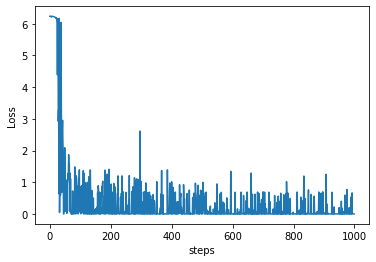

<Figure size 432x288 with 0 Axes>

In [51]:
tp.plot(loss1_t)
tp.xlabel('steps')
tp.ylabel('Loss')
tp.show()
tp.savefig('/content/drive/MyDrive/entropy.png')


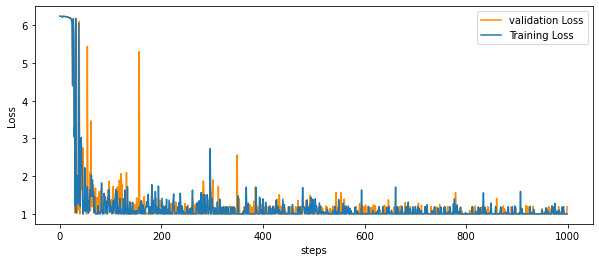

<Figure size 432x288 with 0 Axes>

In [52]:
f = tp.figure()
f.set_figwidth(10)
tp.plot(torch.Tensor(loss_v),label='validation Loss', color='darkorange')
tp.plot(torch.Tensor(loss1_t)+torch.Tensor(loss3_t),label='Training Loss')
#tp.plot(torch.Tensor(loss_v),label='Validation Loss', color='darkorange')
tp.xlabel('steps')
tp.ylabel('Loss')
tp.legend()
tp.show()
tp.savefig('/content/drive/MyDrive/loss.png')

In [53]:
wordscore= model(x = encoded_input)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [54]:
#model = WordImportance()
#model.load_state_dict(torch.load('/content/drive/MyDrive/wordimportance4.pt'))

In [55]:
result_for_rouge = []
for i, x in enumerate(small_test_dataset):
  # Forward pass            
  article_text = Btokenizer(x['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
  article_attention = model(x = article_text)
  text_to_extract = Btokenizer.decode(article_text['input_ids'][0].tolist())
  if i<10:
    loss = -torch.mul(article_attention,article_attention.log()).sum()
    print(loss)

  summary, sentence_position2, sentence_H,sentence_P = summary_generator2(text_to_extract, article_attention,3)
  result_for_rouge.append({'article':x['article'],'golden summary':x['highlights'],'summary':summary,'id':x['id'],'sentence_position':sentence_position2})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.0264, device='cuda:0', grad_fn=<NegBackward0>)
tensor(2.5417e-15, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.9605e-08, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1.8678e-07, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1.4204e-14, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1.1921e-07, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.9605e-08, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4586e-15, device='cuda:0', grad_fn=<NegBackward0>)


In [56]:
rouge1_score = []
rouge2_score = []
rougeL_score = []
for result in result_for_rouge:
  rouge_score = rouge.score(result['golden summary'],result['summary'])
  rouge1_score.append(rouge_score['rouge1'][-1])
  rouge2_score.append(rouge_score['rouge2'][-1])
  rougeL_score.append(rouge_score['rougeL'][-1])

rouge1_score = torch.Tensor(rouge1_score)
rouge2_score = torch.Tensor(rouge2_score)
rougeL_score = torch.Tensor(rougeL_score)

In [57]:
print(rouge1_score.mean())
print(rouge2_score.mean())
print(rougeL_score.mean())

tensor(0.3161)
tensor(0.1175)
tensor(0.1989)


In [58]:
best_example = result_for_rouge[torch.where(rouge1_score==rouge1_score.max())[0].tolist()[0]]
best_example

{'article': "This dog certainly is his master's best friend after saving him from a cold and muddy grave. The black pooch was filmed in action as he took a rescue rope out to his owner at the Clarence J. Brown Dam and Reservoir in Springfield, Ohio, on Saturday afternoon. Footage shows the unidentified man then being hauled to shore by firefighters after spending almost two hours in waters\xa0hovering\xa0around zero degrees\xa0Celsius. He apparently got stuck waist-deep in mud while recovering some duck hunting gear. Luckily, he had a cell phone on hand to call 911. However, first responders were unable to get a boat out to him because\xa0the river was too shallow. They also didn't want to send anyone into the pond in fear\xa0that\xa0they would get stuck too. That's when they had the idea to send the dog in with a rescue rope. Go fetch: This dog certainly is his master's best friend after saving him from a cold and muddy grave . The black pooch was filmed in action as he took a rescue 

In [59]:
article_text = Btokenizer(best_example['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
article_attention = model(x = article_text)
text_to_extract = Btokenizer.decode(article_text['input_ids'][0].tolist())

summary, sentence_position2,sentence_H,sentence_P = summary_generator2(text_to_extract,article_attention,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [60]:
split_text = summary_generator2.text_split(text_to_extract)
truncation_len = summary_generator2.get_truncation_length(split_text)

In [61]:
truncation_len = torch.Tensor(truncation_len)
truncation_len[range(sentence_position2[0])].sum()
select_word=[]
for i in sentence_position2:
  select_word+=list(range(int(truncation_len[range(i)].sum().item()),
                        int(truncation_len[range(i+1)].sum().item())))

In [62]:
color = []
for i in range(512):
  if i in select_word:
    color.append("darkorange")
  else:
    color.append("Wheat")

In [63]:
plt.rcParams["font.family"] = "Times New Roman"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


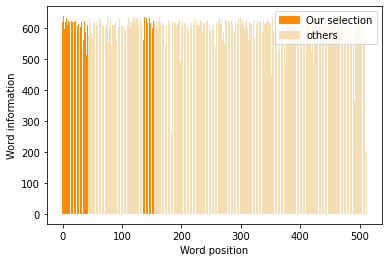

<Figure size 432x288 with 0 Axes>

In [64]:
#x=((-article_attention.log().reshape(512))-(-article_attention.log().reshape(512)).mean())/(-article_attention.log().reshape(512)).std()
x_mean = -torch.mul(article_attention,article_attention.log()).reshape(1,512).sum()
x_std = torch.sqrt(torch.mul(article_attention,(-article_attention.log())**2).reshape(1,512).sum()-x_mean**2)
x=((-article_attention.log()-x_mean)/x_std).reshape(512)
x = x.tolist()
y=list(range(512))

plt.bar(y,x,color=color)
plt.xlabel('Word position')
plt.ylabel('Word information')

color_chosen = {'Our selection':'darkorange','others':'wheat'}
labels = list(color_chosen.keys())
handles = [plt.Rectangle((1,1),0,0, color=color_chosen[label]) for label in labels]
plt.legend(handles, labels)
plt.show()
plt.savefig('/content/drive/MyDrive/truncation_after.png')


In [65]:
sentence_position = []
for x in result_for_rouge:
  sentence_position.append(x['sentence_position'])

sentence_portion = []
for comb in sentence_position:
  sentence_portion+=list(comb)

r1 = 27
appear_position = list(range(r1+1))
sentence_propotion2 = []
for i in appear_position:
  sentence_propotion2.append(sentence_portion.count(i)/len(small_test_dataset))

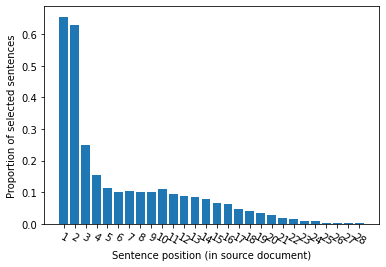

<Figure size 432x288 with 0 Axes>

In [66]:
plt.bar(list(range(1,r1+2)),sentence_propotion2)
plt.xlabel('Sentence position (in source document)')
plt.ylabel('Proportion of selected sentences')
plt.xticks(list(range(1,r1+2)),rotation = -30)
plt.show()
plt.savefig('/content/drive/MyDrive/sentence_position1.png')


In [67]:
result_for_rouge = []
summary_generator = SummaryGenerator().to(device)
for i, x in enumerate(small_test_dataset):
  # Forward pass            
  article_text = Btokenizer(x['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
  article_attention = model(x = article_text)
  text_to_extract = Btokenizer.decode(article_text['input_ids'][0].tolist())
  if i<10:
    loss = -torch.mul(article_attention,article_attention.log()).sum()
    print(loss)

  summary, sentence_position,sentence_score = summary_generator(text_to_extract,article_attention,3)
  result_for_rouge.append({'article':x['article'],'golden summary':x['highlights'],'summary':summary,'id':x['id'],'sentence_position':sentence_position})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.0022, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0127, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-1.1921e-07, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.1158, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.6251, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1.1921e-07, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8210e-07, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<NegBackward0>)


In [68]:
rouge1_score = []
rouge2_score = []
rougeL_score = []
for result in result_for_rouge:
  rouge_score = rouge.score(result['golden summary'],result['summary'])
  rouge1_score.append(rouge_score['rouge1'][-1])
  rouge2_score.append(rouge_score['rouge2'][-1])
  rougeL_score.append(rouge_score['rougeL'][-1])

rouge1_score = torch.Tensor(rouge1_score)
rouge2_score = torch.Tensor(rouge2_score)
rougeL_score = torch.Tensor(rougeL_score)
print(rouge1_score.mean())
print(rouge2_score.mean())
print(rougeL_score.mean())

tensor(0.2820)
tensor(0.0937)
tensor(0.1717)


In [69]:
best_example = result_for_rouge[torch.where(rouge1_score==rouge1_score.max())[0].tolist()[0]]
best_example

{'article': "Priscilla Presley will serve as a witness at the first wedding to be held at an all-new chapel of love in Las Vegas. The 69-year-old collaborated with NBC's\xa0Today show to launch a contest for one Elvis-obsessed couple to win the 'ultimate wedding'. The winning duo - announced next Monday - will tie the knot at Elvis Presley's Graceland Wedding Chapel inside the Westgate Hotel on Thursday, April 23. Novel idea: Priscilla Presley will serve as a witness at the first wedding to be held at an all new chapel of love in Las Vegas . Westgate, formerly the Las Vegas Hilton, is where Elvis performed more than 830 sold-out shows. Along with the singer's former wife in the audience, the winning couple will  win a free wedding reception and hotel suite for two nights. To top it off, airfares and concert tickets to the Elvis Experience theater show will also be thrown in. While Priscilla agreed to make an appearance, the woman who wed Elvis in 1967 made one thing clear before unveil

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


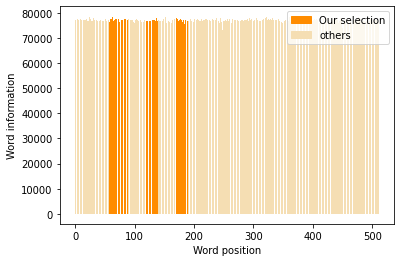

<Figure size 432x288 with 0 Axes>

In [70]:

article_text = Btokenizer(best_example['article'], padding="max_length", truncation=True, return_tensors='pt').to(device)
article_attention = model(x = article_text)
text_to_extract = Btokenizer.decode(article_text['input_ids'][0].tolist())

summary, sentence_position2,sentence_H,sentence_P = summary_generator2(text_to_extract,article_attention,3)
split_text = summary_generator2.text_split(text_to_extract)
truncation_len = summary_generator2.get_truncation_length(split_text)

truncation_len = torch.Tensor(truncation_len)
truncation_len[range(sentence_position2[0])].sum()
select_word=[]
for i in sentence_position2:
  select_word+=list(range(int(truncation_len[range(i)].sum().item()),
                        int(truncation_len[range(i+1)].sum().item())))
  
color = []
for i in range(512):
  if i in select_word:
    color.append("darkorange")
  else:
    color.append("Wheat")

x_mean = -torch.mul(article_attention,article_attention.log()).reshape(1,512).sum()
x_std = torch.sqrt(torch.mul(article_attention,(-article_attention.log())**2).reshape(1,512).sum()-x_mean**2)
x=((-article_attention.log()-x_mean)/x_std).reshape(512)
x = x.tolist()
y=list(range(512))

plt.bar(y,x,color=color)
plt.xlabel('Word position')
plt.ylabel('Word information')

color_chosen = {'Our selection':'darkorange','others':'wheat'}
labels = list(color_chosen.keys())
handles = [plt.Rectangle((1,1),0,0, color=color_chosen[label]) for label in labels]
plt.legend(handles, labels)
plt.show()
plt.savefig('/content/drive/MyDrive/truncation_after.png')


In [71]:
sentence_position = []
for x in result_for_rouge:
  sentence_position.append(x['sentence_position'])

sentence_portion = []
for comb in sentence_position:
  sentence_portion+=list(comb)

r1 = 27
appear_position = list(range(r1+1))
sentence_propotion = []
for i in appear_position:
  sentence_propotion.append(sentence_portion.count(i)/len(small_test_dataset))

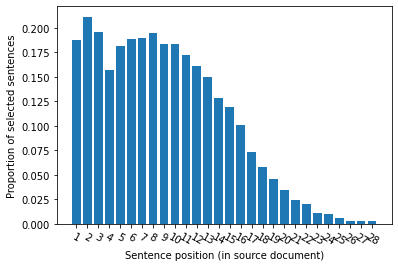

<Figure size 432x288 with 0 Axes>

In [72]:
plt.bar(list(range(1,r1+2)),sentence_propotion)
plt.xlabel('Sentence position (in source document)')
plt.ylabel('Proportion of selected sentences')
plt.xticks(list(range(1,r1+2)),rotation = -30)
plt.show()
plt.savefig('/content/drive/MyDrive/sentence_position2.png')


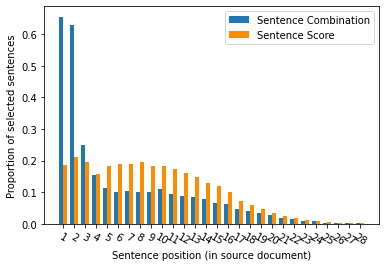

<Figure size 432x288 with 0 Axes>

In [73]:
import numpy as np
width = 0.35  # the width of the bars
x = np.arange(1,r1+2)

plt.bar(x - width/2, sentence_propotion2, width, label='Sentence Combination')
plt.bar(x + width/2, sentence_propotion, width, label='Sentence Score',color='darkorange')

plt.xlabel('Sentence position (in source document)')
plt.ylabel('Proportion of selected sentences')
plt.xticks(list(range(1,r1+2)),rotation = -30)
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/sentence_position3.png')

In [76]:
example = "This dog certainly is his master's best friend after saving him from a cold and muddy grave. The black pooch was filmed in action as he took a rescue rope out to his owner at the Clarence J. Brown Dam and Reservoir in Springfield, Ohio, on Saturday afternoon. Footage shows the unidentified man then being hauled to shore by firefighters after spending almost two hours in waters\xa0hovering\xa0around zero degrees\xa0Celsius. He apparently got stuck waist-deep in mud while recovering some duck hunting gear. Luckily, he had a cell phone on hand to call 911. However, first responders were unable to get a boat out to him because\xa0the river was too shallow. They also didn't want to send anyone into the pond in fear\xa0that\xa0they would get stuck too. That's when they had the idea to send the dog in with a rescue rope. Go fetch: This dog certainly is his master's best friend after saving him from a cold and muddy grave . The black pooch was filmed in action as he took a rescue rope out to his owner at the Clarence J. Brown Dam and Reservoir in Springfield, Ohio, on Saturday afternoon . All hands on deck: Footage shows the unidentified man then being hauled to shore by firefighters after spending almost two hours in waters hovering around zero degrees Celsius . Wrong move: He apparently got stuck waist-deep in mud while recovering some duck hunting gear . According to the Springfield News-Sun, the man remained in good spirits throughout his recovery and didn't suffer any injuries. Assistant Fire Chief Rick Hughes said that if the ordeal had gone on much longer it could have proved fatal. 'It’s a good thing he had his cellphone considering he was in the mud and water to about his chest and it was about 33 degrees [Fahrenheit],' he added.",
article_text = Btokenizer(example, padding="max_length", truncation=True, return_tensors='pt').to(device)
article_attention = model(x = article_text)
text_to_extract = Btokenizer.decode(article_text['input_ids'][0].tolist())

summary, sentence_position,sentence_score = summary_generator(text_to_extract,article_attention,3)
summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"they also didn't want to send anyone into the pond in fear that they would get stuck too. according to the springfield news - sun, the man remained in good spirits throughout his recovery and didn't suffer any injuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]